Generate FEM solution for 2D plane stress problem

* Output dirich_idx, dirich_value; traction_idx, traction_value; bodyforce; solution; materials (E, v)
* The unit is GPa
* Please note that the node numbering in FEM and CNN is reverse in y direction

In [1]:
from PIL import Image

import meshio
import numpy as np
import matplotlib.pyplot as plt
import gaussian_random_fields as gr
import random
import h5py

#### Import the image

In [2]:
samples = ['G5v', 'G6a', 'Y6v', 'Y6a']
# im = Image.open(sample+'_XZ_128_new.tif')
im = Image.open(samples[0]+'_XZ_256.tif')
# im = Image.open('amga6__rec00001201_yz_select280_erode+dilate.tif')
# imarray = np.flip(np.array(im)/255, axis=0)
imarray = np.array(im)/255

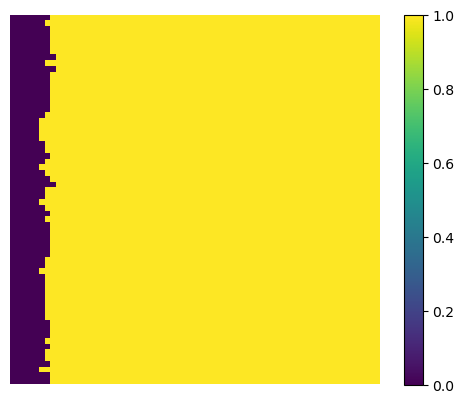

In [3]:
def plot_image(img):
    fig = plt.figure()
    im1 = plt.imshow(img)
    plt.axis('off')
    plt.colorbar(im1)

# reduce the size of the image
times = 4
imarray = imarray[::times, ::times]
plot_image(imarray) # note this is the element distribution

#### Define the FEA class

In [4]:
def project_input(input_array):
    '''
    Helps to project an element format binary image to a node format image.
    
    For a numpy 2d binary array input. The element 1 can project to output as 
    [[1,1],[1,1]], while 0 can project to output as [[0,0],[0,0]]. 
    The output of nearby input element will have boolean operation in common edge. '''
    rows, cols = input_array.shape
    output_shape = (rows + 1, cols + 1)
    output = np.zeros(output_shape, dtype=int)

    mask = (input_array == 1)
    output[:rows, :cols] = mask
    output[1:, 1:] = np.logical_or(output[1:, 1:], mask)
    output[1:, :cols] = np.logical_or(output[1:, :cols], mask)
    output[:rows, 1:] = np.logical_or(output[:rows, 1:], mask)

    return output

In [5]:
class MeshSquareFEM():
    """ 
    Handle a simple square mesh with quad elements
    Given input of image, boundary nodes, and connections
    """

    def __init__(self, hsize, mask, dirich_idx, neumann_conn_list, outfile = None):
        '''The mask shows the element mask, indicate whether there is any valid element'''
        self.hsize = hsize
        self.img_h, self.img_w = mask.shape
        self.mask = mask # mask has the value of 0 or 1
        self.dirich_idx = dirich_idx # Dirichlet idx has shape of (h, w, 2)
        self.neumann_conn_list = neumann_conn_list # list of neumann_conn
        self.points, self.cells = self.generate_mesh()
        self.generate_node_index()
        
        if outfile is not None:
            self.save_mesh(outfile)

    def generate_mesh(self):
        x = np.linspace(0,self.hsize * self.img_w,self.img_w+1, dtype=np.float64)
        y = np.linspace(0,self.hsize * self.img_h,self.img_h+1, dtype=np.float64)
        ms_x, ms_y = np.meshgrid(x,y)
        x = np.ravel(ms_x).reshape(-1,1)
        y = np.ravel(ms_y).reshape(-1,1)
        z = np.zeros_like(x, dtype=np.float64)
        points = np.concatenate((x,y,z),axis=1)
        n_element = self.img_h * self.img_w
        nodes = np.linspace(0,points.shape[0],points.shape[0],endpoint=False,dtype=int).reshape(self.img_h+1,self.img_w+1)
        cells = np.zeros((n_element,4),dtype=int)
        cells[:,0] = np.ravel(nodes[:self.img_w,:self.img_h])
        cells[:,1] = np.ravel(nodes[:self.img_w,1:])
        cells[:,2] = np.ravel(nodes[1:,1:])
        cells[:,3] = np.ravel(nodes[1:,:self.img_h])
        has_element = self.mask > 1e-6 # elements that occupied by materials
        cells = cells[has_element.reshape(-1)]
        self.mesh = meshio.Mesh(points, [("quad",cells)]) # generate a mesh used for output
        return points, cells
    
    def generate_node_index(self):
        # generate global node index 
        self.nodes = np.arange((self.img_h+1)*(self.img_w+1))
        self.valid_node = np.unique(self.cells.reshape(-1))
        self.nonvalid_node = np.setdiff1d(self.nodes,self.valid_node)

        # generate global dof
        self.df_nodes = np.repeat(2*self.nodes,2)+np.tile([0,1],self.nodes.shape[0])
        self.df_valid = np.repeat(2*self.valid_node,2)+np.tile([0,1],self.valid_node.shape[0])
        self.df_nonvalid = np.repeat(2*self.nonvalid_node,2)+np.tile([0,1],self.nonvalid_node.shape[0])
        
        # generate boundary dof
        dof_idx = np.where(self.dirich_idx.reshape(-1) == 1) # dirich dof index
        self.df_dirich = self.df_nodes[dof_idx]
        self.df_dirich_plus_nonvalid = np.concatenate((self.df_dirich,self.df_nonvalid))
        self.df_ndirich_valid = np.setdiff1d(self.df_valid,self.df_dirich)

    def shapefunc(self, p):
        # shape function
        N = 0.25*np.array([[(1-p[0])*(1-p[1])],
                           [(1+p[0])*(1-p[1])],
                           [(1+p[0])*(1+p[1])],
                           [(1-p[0])*(1+p[1])]])

        dNdp = 0.25*np.array([[-(1-p[1]), -(1-p[0])],
                              [(1-p[1]), -(1+p[0])],
                              [(1+p[1]), (1+p[0])],
                              [-(1+p[1]), (1-p[0])]])
        return N, dNdp

    def save_mesh(self,outfile = 'mesh_square.vtk'):
        self.mesh.write(outfile)

In [6]:
class GridFEM():
    '''
    Note: input the mesh grid, material, bc and f values, generate a finite element problem
    '''
    def __init__(self, grid, material, dirich_val, neumann_val, f_val):
        self.grid = grid
        self.res_arr = []
        self.qpts = np.array([[-1, 1, 1, -1], [-1, -1, 1, 1]])/np.sqrt(3) #[2x4], integration points
        self.n_nodes = grid.points.shape[0]
        self.d = np.zeros(2*self.n_nodes, dtype=np.float64) # x,y components
        self.f = np.zeros_like(f_val, dtype=np.float64)
        self.residual = np.zeros_like(self.d)
        self.ku = np.zeros_like(self.d)

        # create cell data
        self.grid.mesh.cell_data['E'] = material[:, :, 0].reshape(-1)
        self.grid.mesh.cell_data['v'] = material[:, :, 1].reshape(-1)

        # generate a finite element problem
        self.DirichBC(dirich_val)
        self.UpdateBodyForce(f_val)
        self.NeumannBC(neumann_val)
        self.A, self.A_F, self.A_EF = self.CreateA()

    def CreateA(self):
        '''
        Stiffness matrix, return A_F and A_EF
        Subscript E means essential boundary nodes, F means all remaining valid nodes
        ''' 
        A = np.zeros((2*self.n_nodes,2*self.n_nodes))
        for i, c in enumerate(self.grid.cells):
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            E = self.grid.mesh.cell_data['E'][i]
            v = self.grid.mesh.cell_data['v'][i]
            D = E/(1.-v*v)*np.array([[1., v, 0.], [v, 1., 0.], [0., 0., (1.-v)/2.]]) # plane stress

            Ke = np.zeros((8,8))
            for q in self.qpts.T:
                [_,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                dNdx = np.dot(dNdp, np.linalg.inv(J)) #[4x2]
                B = np.zeros((3,8))
                B[0, 0::2] = dNdx[:,0]
                B[1, 1::2] = dNdx[:,1]
                B[2, 0::2] = dNdx[:,1]
                B[2, 1::2] = dNdx[:,0]
                Ke += np.linalg.det(J)*np.dot(B.T,np.dot(D,B))
            cc = np.zeros((8,), dtype=int)
            cc[0::2] = 2*c
            cc[1::2] = 2*c+1
            A[np.ix_(cc,cc)] += Ke
            
        return A, A[np.ix_(self.grid.df_ndirich_valid,self.grid.df_ndirich_valid)], A[np.ix_(self.grid.df_dirich_plus_nonvalid,self.grid.df_ndirich_valid)]
        
        
    def UpdateBodyForce(self, f_val = None):
        '''
        Input: f_val is a 1-D array that contains both x and y degree of freedom
        '''
        for c in self.grid.cells:
            xe = self.grid.points[c,:].T[:2,:] #[2x4]
            for q in self.qpts.T:
                [N,dNdp] = self.grid.shapefunc(q)
                J = np.dot(xe, dNdp) #[2x2]
                self.f[2*c] += np.linalg.det(J)*np.dot(N,np.dot(N.T,f_val[2*c]))
                self.f[2*c+1] += np.linalg.det(J)*np.dot(N,np.dot(N.T,f_val[2*c+1]))

    def NeumannBC(self, bc_val):
        '''
        Input: bc_val is a 1-D array that contains both x and y degree of freedom
        '''
        for neumann_conn in self.grid.neumann_conn_list:
            for c in neumann_conn:
                xe = self.grid.points[c,:][:,:2] #[2x2]
                le = np.linalg.norm(xe[1,:]-xe[0,:])
                for q in [1./np.sqrt(3), -1./np.sqrt(3)]:
                    N = 0.5*np.array([1-q, 1+q])
                    self.f[2*c] += np.dot(N,np.dot(N.T,bc_val[2*c]))*le/2 
                    self.f[2*c+1] += np.dot(N,np.dot(N.T,bc_val[2*c+1]))*le/2 

    def DirichBC(self, bc_val):
        self.d[self.grid.df_nonvalid] = 0.0 # response should be zero at nonvalid nodes
        self.d[self.grid.df_dirich] = bc_val[self.grid.df_dirich]

    def GaussianRF(self, n, a_interval):
        '''
        Only works for a square mesh
        '''
        alpha = random.uniform(2,5)
        a0, a1 = a_interval[0],a_interval[1]
        field = gr.gaussian_random_field(alpha=alpha, size=n, flag_normalize=False)
        f_min, f_max = np.min(field), np.max(field)
        rf = (a1-a0)*(field-f_min)/(f_max-f_min)+a0
        return rf

    def Solve(self):
        '''
        Solve the linear equation system
        '''
        b_F = self.f[self.grid.df_ndirich_valid] - np.dot(self.A_EF.T, self.d[self.grid.df_dirich_plus_nonvalid])
        # d_F = np.linalg.solve(self.A_F, b_F)
        # res_F, ku_F = np.zeros_like(d_F), np.zeros_like(d_F)
        d_F, res_F, ku_F = self.Jacobi(self.A_F, b_F, np.zeros_like(b_F))
        self.d[self.grid.df_ndirich_valid] = d_F
        self.residual[self.grid.df_ndirich_valid] = res_F
        self.ku[self.grid.df_ndirich_valid] = ku_F

    def Jacobi(self, A, b, u0):
        Dinv = np.diag(1./np.diag(A))
        N = 0
        u = u0
        omega = 2./3.
        res = 1
        uprev = u
        ku = np.dot(A, uprev)
        residual = b - np.dot(A, uprev)
        res = np.linalg.norm(residual)
        while(res > 1e-6 and N < 1000):
            u = omega*np.dot(Dinv, residual) + uprev
            ku = np.dot(A, u)
            residual = b - np.dot(A, u)
            res = np.linalg.norm(residual)
            self.res_arr.append(res)
            uprev = u
            print(N, res)
            N += 1

        return u, residual, ku
    
    def PlotField(self, field = None):
        '''Default is to plot the solution field'''
        if(field is None):
            field = self.d
        
        h, w = self.grid.img_h+1, self.grid.img_w+1
        self.x_disp = field[0::2].reshape((h, w))
        self.y_disp = field[1::2].reshape((h, w))

        fig = plt.figure()

        fig.add_subplot(1,2,1)
        im1 = plt.imshow(self.x_disp, origin='lower')
        plt.axis('off')
        plt.title('X')
        plt.colorbar(im1)

        fig.add_subplot(1,2,2)
        im2 = plt.imshow(self.y_disp, origin='lower')
        plt.axis('off')
        plt.title('Y')
        plt.colorbar(im2)

        plt.tight_layout()
        plt.show()

#### Define the boundary conditions

In [7]:
def find_surrounding(img, pt):
    '''
    Given a point, return a list of points that are surrounding of current points inside the image
    Sequence starts from top left.
    '''
    temp = [[pt[0]-1,pt[1]-1],
            [pt[0]-1,pt[1]],
            [pt[0]-1,pt[1]+1],
            [pt[0],pt[1]-1],
            [pt[0],pt[1]+1],
            [pt[0]+1,pt[1]-1],
            [pt[0]+1,pt[1]],
            [pt[0]+1,pt[1]+1]]
    surrounding = [0, 1, 2, 3, 4, 5, 6, 7]
    dict_surrounding = dict(zip(surrounding, temp))
    h, w = img.shape
    for i, p in enumerate(temp):
        if(p[0] < 0 or p[1] < 0 or p[0] >= h or p[1] >= w):
            del dict_surrounding[i]
    return dict_surrounding

def reorder_connection(neumann_conn):
    '''
    Given a list of connected nodes, write a function to let it to be head-tail connected. 
    The order of each connection can be changed. For example if the input is 
    [[1,2],[2,4],[6,5],[4,3],[3,5]], the output should be 
    [[1,2],[2,4],[4,3],[3,5],[5,6]]. The first element of input should keep unchanged. 

    Input: neumann_conn, a list with each element is a two-element sublist
    Output: corrected order neumann_conn 
    '''

    graph = {}
    for a, b in neumann_conn:
        graph.setdefault(a, []).append(b)
        graph.setdefault(b, []).append(a)

    visited = set()
    result = []

    def dfs(node):
        for neighbor in graph[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                result.append([node, neighbor])
                dfs(neighbor)

    # Start from the first node in the input
    start_node = neumann_conn[0][0]
    visited.add(start_node)
    dfs(start_node)

    return np.array(result)

def define_left_nodes(img):
    '''
    Define the left boundary, also need to define connection. Please note that 
    this complex function needs to be validated if used in other cases. 

    The node id is arranged by row-first approach
    '''
    h_img, w_img = img.shape
    left = np.zeros((h_img+1, w_img+1))
    left_conn = []
    for i in range(h_img):
        for j in range(w_img):
            if(img[i,j]==1): # if there is material in current pixel i, j
                surrounding = find_surrounding(img, [i,j]) # surrounding pixels
                for key in surrounding: 
                    pt = surrounding[key]
                    if(img[pt[0],pt[1]]==0):
                        if(key == 0):
                            left[i,j] = 1
                        if(key == 1):
                            left[i,j] = 1
                            left[i,j+1] = 1
                            left_conn.append([
                                i*(w_img+1)+j,i*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 2):
                            left[i,j+1] = 1
                        if(key == 3):
                            left[i,j] = 1
                            left[i+1,j] = 1
                            left_conn.append([
                                i*(w_img+1)+j,(i+1)*(w_img+1)+j
                            ]) # generate a connection
                        if(key == 4):
                            left[i,j+1] = 1
                            left[i+1,j+1] = 1
                            left_conn.append([
                                i*(w_img+1)+j+1,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 5):
                            left[i+1,j] = 1
                        if(key == 6):
                            left[i+1,j] = 1
                            left[i+1,j+1] = 1
                            left_conn.append([
                                (i+1)*(w_img+1)+j,(i+1)*(w_img+1)+j+1
                            ]) # generate a connection
                        if(key == 7):
                            left[i+1,j+1] = 1

    return [left], [reorder_connection(left_conn)]

In [8]:
def define_right_nodes(node_mask):
    '''
    Input is the node mask
    Define top/bottom/right boundaries and their connections
    '''
    node = np.zeros_like(node_mask)
    node[:,-1] = 1
    node = (node * node_mask)
    node_idx = np.where(node.reshape(-1) == 1)
    conn = np.stack((node_idx[0][:-1],node_idx[0][1:]), axis=-1)
    return [node], [reorder_connection(conn)]

def define_top_nodes(node_mask):
    '''
    Input is the node mask
    Define top/bottom/right boundaries and their connections
    '''
    node = np.zeros_like(node_mask)
    node[-1,:] = 1
    node = (node * node_mask)
    node_idx = np.where(node.reshape(-1) == 1)
    conn = np.stack((node_idx[0][:-1],node_idx[0][1:]), axis=-1)
    return [node], [reorder_connection(conn)]

def define_bottom_nodes(node_mask):
    '''
    Input is the node mask
    Define top/bottom/right boundaries and their connections
    '''
    node = np.zeros_like(node_mask)
    node[0,:] = 1
    node = (node * node_mask)
    node_idx = np.where(node.reshape(-1) == 1)
    conn = np.stack((node_idx[0][:-1],node_idx[0][1:]), axis=-1)
    return [node], [reorder_connection(conn)]

#### Define the loading types

In [9]:
def combine_vectors(v):
    '''combine vectors v (n, n, 2) to (nxnx2)'''
    _, n, _ = v.shape
    u = np.zeros(shape=(2*n*n,))
    u[0::2] = v[:, :, 0].reshape(n*n)
    u[1::2] = v[:, :, 1].reshape(n*n)
    return u

def split_vectors(v):
    '''split vectors v from (nxnx2) to (n, n, 2) '''
    nn = v.shape[0]
    n = int(np.sqrt(nn/2))
    u = np.zeros(shape=(n, n, 2))
    u[:,:,0] = v[0::2].reshape(n, n)
    u[:,:,1] = v[1::2].reshape(n, n)
    return u

def loading_type1(node_mask, boundary_ndlist):
    '''
    boundary node list: [top, bottom, right, left]

    Loading (0 is x, 1 is y direction): 
    Fix the top boundary, apply random loading at bottom boundary
    '''
    h, w = node_mask.shape
    top_idx = np.where(boundary_ndlist[0] == 1)
    bottom_idx = np.where(boundary_ndlist[1] == 1)
    right_idx = np.where(boundary_ndlist[2] == 1)
    left_idx = np.where(boundary_ndlist[3] == 1)

    # define dirich boundary (use for FEA and FEA-Net)
    dirich_idx = np.zeros((h, w, 2), dtype=np.int32)
    dirich_idx[top_idx[0], top_idx[1], 0] = 1 # fix displacement in x
    dirich_idx[top_idx[0], top_idx[1], 1] = 1 # fix displacement in y
    dirich_value = np.zeros_like(dirich_idx)

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask.reshape(h,w,1)

    # define traction boundary, 1.0 traction boundary; 0 else
    traction_idx = np.zeros((h, w, 2), dtype=np.int32)
    traction_value = np.zeros_like(traction_idx)
    traction_idx[bottom_idx[0], bottom_idx[1], 0] = 1 
    traction_value[bottom_idx[0], bottom_idx[1], 0] = 10 # apply force in x, N
    traction_idx[bottom_idx[0], bottom_idx[1], 1] = 1 
    traction_value[bottom_idx[0], bottom_idx[1], 1] = 15 # apply force in y, N

    return dirich_idx, dirich_idx_feanet, dirich_value, traction_idx, traction_value

#### Define the problem

In [10]:
datafile = "elastic_Ti64.h5"
hsize = 0.0061*times # mm
elem_mask = np.copy(imarray)
h, w = elem_mask.shape
material = np.ones((h, w, 2))
material[:,:,0] *= 110e3 # E, MPa
material[:,:,1] *= 0.34 # v
node_mask = project_input(elem_mask)
left_ndlist, left_conn = define_left_nodes(node_mask)
right_ndlist, right_conn = define_right_nodes(node_mask)
top_ndlist, top_conn = define_top_nodes(node_mask)
bottom_ndlist, bottom_conn = define_bottom_nodes(node_mask)
boundary_ndlist = top_ndlist+bottom_ndlist+right_ndlist+left_ndlist
neumann_connlist = bottom_conn
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, boundary_ndlist)
f_val = np.zeros_like(dirich_val)


In [11]:
# generate a mesh grid
grid = MeshSquareFEM(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [12]:
# generate FEM problem
problem = GridFEM(grid, material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))

0 2.6202542618069744
1 2.0578732660241745
2 1.9689921479581718
3 1.8384200999646734
4 1.7776717029797358
5 1.7132734287688807
6 1.6663325581893558
7 1.622624628202905
8 1.5858253488403324
9 1.5524453674024898
10 1.52284459241496
11 1.4959071944534332
12 1.4714400534979706
13 1.448965463465527
14 1.4282597652002058
15 1.4090627736572259
16 1.3911996377333027
17 1.374505597887335
18 1.3588523626896252
19 1.3441264274190134
20 1.3302336122811311
21 1.3170917432812326
22 1.3046304936256758
23 1.2927883600031786
24 1.2815117526403597
25 1.2707534703081793
26 1.2604718740503993
27 1.2506299922455864
28 1.2411948959191685
29 1.2321371204380551
30 1.223430212826147
31 1.2150503357619564
32 1.2069759406473117
33 1.1991874863390843
34 1.1916672007453846
35 1.1843988758906137
36 1.1773676916460134
37 1.1705600634437554
38 1.1639635100260985
39 1.1575665384114886
40 1.1513585432542421
41 1.1453297186962432
42 1.1394709807600523
43 1.1337738989289308
44 1.1282306355649474
45 1.1228338921774454
46 1

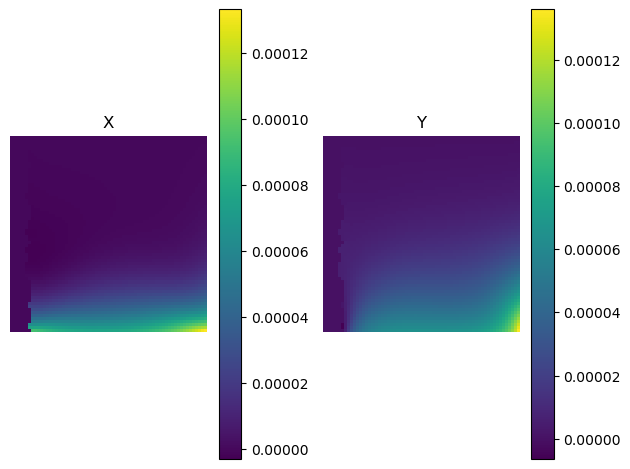

In [13]:
problem.Solve()
problem.PlotField()

#### Create dataset

In [14]:
def conn_list2array(node_mask, conn_list):
    '''Convert a connection list into nparrays '''
    h, w = node_mask.shape
    conn_array = np.zeros((h,w,len(conn_list)))
    for i in range(len(conn_list)):
        conn_len = conn_list[i].shape[0]
        subarray = np.full((h*w),-1) 
        subarray[:conn_len] = conn_list[i][:,0]
        subarray[conn_len] = conn_list[i][-1,1]
        conn_array[:,:,i] = subarray.reshape((h,w))
    return conn_array

In [15]:
n_data = 1
dataset = {}
dirich_idx_data = np.zeros((n_data, h+1, w+1, 2))
dirich_value_data = np.zeros((n_data, h+1, w+1, 2))
traction_idx_data = np.zeros((n_data, h+1, w+1, 2))
traction_value_data = np.zeros((n_data, h+1, w+1, 2))
tranction_conn_data = n_data*[[]]
mask_data = np.zeros((n_data, h+1, w+1, 1))
material_data = np.zeros((n_data, h, w, 2))
f_data = np.zeros((n_data, h+1, w+1, 2))
u_data = np.zeros((n_data, h+1, w+1, 2))
neumann_conn_data = np.zeros((n_data, h+1, w+1, 2))
for i in range(n_data):
    dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val = loading_type1(node_mask, boundary_ndlist)
    problem = GridFEM(grid, material, dirich_val.reshape(-1), neumann_val.reshape(-1), f_val.reshape(-1))    
    problem.Solve()
    material_data[i] = material*elem_mask.reshape(h,w,1)
    dirich_idx_data[i] = dirich_idx_feanet
    dirich_value_data[i] = dirich_val
    traction_idx_data[i] = neumann_idx
    traction_value_data[i] = neumann_val
    tranction_conn_data[i] = conn_list2array(node_mask, neumann_connlist)
    f_data[i] = f_val
    u_data[i] = problem.d.reshape((h+1, w+1, 2))
    print("Problem #-"+str(i)+" solved")

    # create mask images
    mask = np.zeros(((h+1)*(w+1),))
    mask[grid.valid_node] = 1
    mask_data[i] = mask.reshape((h+1,w+1,1))

print("Generating the dataset ...")
dataset['mask'] = mask_data
dataset['dirich_idx'] = dirich_idx_data
dataset['dirich_value'] = dirich_value_data
dataset['neumann_idx'] = traction_idx_data
dataset['neumann_value'] = traction_value_data
dataset['neumann_conn'] = tranction_conn_data
dataset['material'] = material_data
dataset['source'] = f_data
dataset['solution'] = u_data

with h5py.File(datafile, "w") as hf:
    for key, item in dataset.items():
        hf[key] = item

0 2.6202542618069744
1 2.0578732660241745
2 1.9689921479581718
3 1.8384200999646734
4 1.7776717029797358
5 1.7132734287688807
6 1.6663325581893558
7 1.622624628202905
8 1.5858253488403324
9 1.5524453674024898
10 1.52284459241496
11 1.4959071944534332
12 1.4714400534979706
13 1.448965463465527
14 1.4282597652002058
15 1.4090627736572259
16 1.3911996377333027
17 1.374505597887335
18 1.3588523626896252
19 1.3441264274190134
20 1.3302336122811311
21 1.3170917432812326
22 1.3046304936256758
23 1.2927883600031786
24 1.2815117526403597
25 1.2707534703081793
26 1.2604718740503993
27 1.2506299922455864
28 1.2411948959191685
29 1.2321371204380551
30 1.223430212826147
31 1.2150503357619564
32 1.2069759406473117
33 1.1991874863390843
34 1.1916672007453846
35 1.1843988758906137
36 1.1773676916460134
37 1.1705600634437554
38 1.1639635100260985
39 1.1575665384114886
40 1.1513585432542421
41 1.1453297186962432
42 1.1394709807600523
43 1.1337738989289308
44 1.1282306355649474
45 1.1228338921774454
46 1